# Prepare raw data for training

Data preparation process includes: 

0. (Before conversion) Place raw data in `data/raw`

1. Copy raw data to `data/interim` and split data into training, testing, and validation sets

2. Downsize data to (256x256) and save to data/procesed

## Step 0: Place raw data in `data/raw`

The raw image data from Zahra consists of identically named '.tif' files of the OCT scans and the labeled ground truth masks. This image data was organized in the following:
```
   └── raw
      └── OCT_scans
         ├── images
         │  ├── img1
         │  ├── img2
         │  ├── ...
         │  └── imgn
         └── masks
            ├── img1
            ├── img2
            ├── ...
            └── imgn
```

## Step 1.1: Copy data to `data/interim`

Raw data should never be modified. Hence it is copied into `data/interim`. This is the data that will be modified.

In [3]:
import shutil
raw_dir = "../data/raw/OCT_scans"
interim_dir = "../data/interim/OCT_scans"
copy_if_dir_exists = True
# Copy directory to interim dir
shutil.copytree(src=raw_dir, dst=interim_dir, dirs_exist_ok=copy_if_dir_exists)

<class 'str'>


Validate the images and masks are expected. Images should be an 8-bit image and masks should be binary labeled as 0 (background) and 1 (foreground)

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import tifffile
import numpy as np
import os
# Get all image names
img_dir = f"{interim_dir}/images"
mask_dir = f"{interim_dir}/masks"
img_names = os.listdir(img_dir)
# Randomly select a single image name
img_name = np.random.choice(img_names)
print(f"NAME:\t{img_name}")

NAME:	train-P (3).tif


IMAGE STATS:
shape:	(512, 512)
dtype:	uint16
min:	0
max:	61270


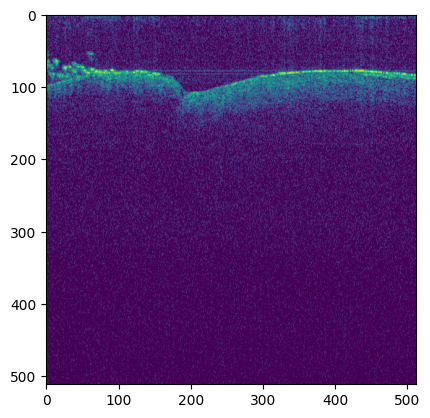

In [11]:
# Show image statistics and image
img_path = f"{img_dir}/{img_name}"
img = tifffile.imread(img_path)
print(f"IMAGE STATS:\nshape:\t{img.shape}\ndtype:\t{img.dtype}\nmin:\t{np.amin(img)}\nmax:\t{np.amax(img)}")
plt.imshow(img)

MASK STATS:
shape:	(512, 512)
dtype:	uint8
min:	0
max:	255
unique:	[  0 255]


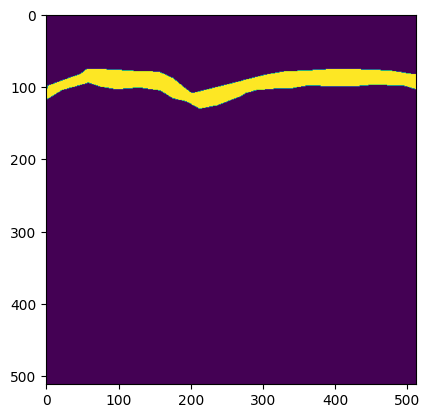

In [12]:
# Show mask statistics and image
mask_path = f"{mask_dir}/{img_name}"
mask = tifffile.imread(mask_path)
print(f"MASK STATS:\nshape:\t{mask.shape}\ndtype:\t{mask.dtype}\nmin:\t{np.amin(mask)}\nmax:\t{np.amax(mask)}\nunique:\t{np.unique(mask)}")
plt.imshow(mask)

## Step 1.2: Converting images to 8-bit images

As shown in the images statistics above, the images are 16-bit images ("dtype: uint16" and "max" is above 255). We will create 8-bit images by linearly downscaling the intensity from a max of $2^{16} - 1$ (16-bit) to a max of $2^8 - 1$ (8-bit).



In [19]:
def to_uint8(img:np.ndarray, scaling:float, offset:float = 0):
    """
    Return image converted to uint8
    
    Pixel-wise intensity formual: I = I*scaling + offset.
    Casts to uint8 before return.
    """
    flt = img.astype(float)
    flt = flt*scaling + offset
    return flt.astype(np.uint8)

scaling = (2**8 - 1)/(2**16 - 1)
for img_name in os.listdir(img_dir):
    img_path = f"{img_dir}/{img_name}"
    img = tifffile.imread(img_path)
    # Linearly downscale intensities to 8-bit and save image
    if img.dtype == 'uint16':
        print(f"Converting {img_name} to 8-bit")
        img = to_uint8(img, scaling)
        tifffile.imwrite(img_path, img)

Converting train-P (11).tif to 8-bit
Converting train-P (12).tif to 8-bit
Converting train-P (13).tif to 8-bit
Converting train-P (14).tif to 8-bit
Converting train-P (15).tif to 8-bit
Converting train-P (16).tif to 8-bit
Converting train-P (17).tif to 8-bit
Converting train-P (18).tif to 8-bit
Converting train-P (19).tif to 8-bit
Converting train-P (2).tif to 8-bit
Converting train-P (20).tif to 8-bit
Converting train-P (21).tif to 8-bit
Converting train-P (22).tif to 8-bit
Converting train-P (23).tif to 8-bit
Converting train-P (24).tif to 8-bit
Converting train-P (25).tif to 8-bit
Converting train-P (26).tif to 8-bit
Converting train-P (27).tif to 8-bit
Converting train-P (28).tif to 8-bit
Converting train-P (29).tif to 8-bit
Converting train-P (3).tif to 8-bit
Converting train-P (30).tif to 8-bit
Converting train-P (31).tif to 8-bit
Converting train-P (32).tif to 8-bit
Converting train-P (33).tif to 8-bit
Converting train-P (34).tif to 8-bit
Converting train-P (35).tif to 8-bit
Con

Re-validate the images are as expected with 8-bit format.

NAME:	train-P (66).tif
IMAGE STATS:
shape:	(512, 512)
dtype:	uint8
min:	0
max:	254


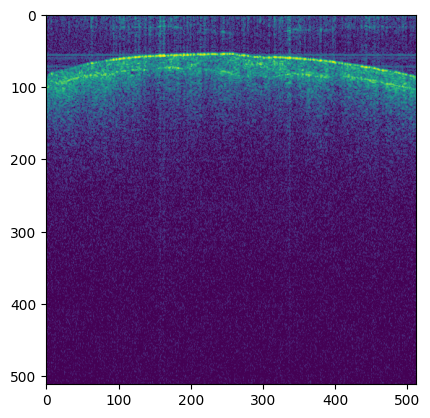

In [20]:
img_names = os.listdir(img_dir)
# Randomly select a single image name
img_name = np.random.choice(img_names)
print(f"NAME:\t{img_name}")
# Show image statistics and image
img_path = f"{img_dir}/{img_name}"
img = tifffile.imread(img_path)
print(f"IMAGE STATS:\nshape:\t{img.shape}\ndtype:\t{img.dtype}\nmin:\t{np.amin(img)}\nmax:\t{np.amax(img)}")
plt.imshow(img)

## Step 1.3: Split data into training, testing, and validation sets

Following steps assume you have an data directory as shown:

```
   └── interim
      └── OCT_scans
         ├── images
         │  ├── img1
         │  ├── img2
         │  ├── ...
         │  └── imgn
         └── masks
            ├── img1
            ├── img2
            ├── ...
            └── imgn
```

Where each "img" has the same filename between images<->masks.

After splitting, you will have the following data structure:
```
   └── interim
      └── OCT_scans
         ├── split
         │  ├── train
         │  │  ├── images
         │  │  └── masks
         │  ├── val
         │  │  ├── images
         │  │  └── masks
         │  └── test
         │     ├── images
         │     └── masks
         ├── images
         │  ├── img1
         │  ├── img2
         │  ├── ...
         │  └── imgn
         └── masks
            ├── img1
            ├── img2
            ├── ...
            └── imgn
```


In [28]:
%load_ext autoreload
%autoreload 2
from src.data.splitting import single_dir_split
data_dir = "../data/interim/OCT_scans"
single_dir_split(data_dir=data_dir, img_dir_name='images', mask_dir_name='masks', split_vals=(70,20,10), ext='.tif')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 77 image-mask pairs from 77 images and 77 masks
copying data from 54 training instances
copying data from 15 validation instances
copying data from 8 testing instances


## Step 1.4: Crop images and resize

Finally, take each image and crop it to a smaller size, resize it even smaller, and then save it. We downsize it drastically to reduce deep learning model overhead.

In [31]:
%load_ext autoreload
%autoreload 2
from src.data.cropping import crop_and_resize_dir
input_dir = f"{data_dir}/split"
output_dir = "../data/processed/OCT_scans_256x256"
crop_and_resize_dir(input_dir=input_dir,output_dir=output_dir, ncrops=1, size=(256, 256), ext=".tif")

INFO: Cropping and resizing ../data/interim/OCT_scans/split\test\images/train-P (1).tif
INFO: Created directory: ../data/processed/OCT_scans_256x256\test\images
INFO: Cropping and resizing ../data/interim/OCT_scans/split\test\images/train-P (10).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\test\images/train-P (46).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\test\images/train-P (50).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\test\images/train-P (56).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\test\images/train-P (65).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\test\images/train-P (68).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\test\images/train-P (74).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\test\masks/train-P (1).tif
INFO: Created directory: ../data/processed/OCT_scans_256x256\test\masks
INFO: Cropping and resizing ../data/interim/OCT_scans/spl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (33).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (34).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (36).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (38).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (39).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (4).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (40).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (41).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (43).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (44).tif
INFO: Cropping and resizing ../data/interim/OCT_scans/split\train\images/train-P (45).tif
INFO: Cropp